# 7-segment displays

This notebook gives a cute example to show off memo's interoperability with the broader JAX ecosystem, which includes deep learning, graphics, physics simulation, and more.

A [seven-segment display](https://en.wikipedia.org/wiki/Seven-segment_display) uses seven lights to display a variety of characters. But when designing a "font" for such a display, [you have to be careful to avoid ambiguities](https://harold.thimbleby.net/cv/files/seven-segment.pdf): for example, a capital "B" and the letter "8" naïvely map to the same pattern (all seven segments on), but are impossible to distinguish. Nonetheless, people have come up with all kinds of [creative variants](https://youtu.be/Th-u84OkpeQ?si=2K01bAX2LjjnXiMJ).

Can we model intuitions about 7-segment displays as a kind of rational communication? To do so, let us start by training a simple neural network model of hand-written character recognition on the EMNIST dataset, using JAX's `flax` ecosystem for deep learning. We will then build a memo model that reasons _over_ this neural network!

(This notebook has a lot of boilerplate/code for training a ResNet. For the most interesting parts, scroll to the end!)

In [1]:
import jax
import jax.numpy as jnp
import numpy as np
import jax.scipy as jsp

import torch
import torchvision.datasets

from matplotlib import pyplot as plt

import os
import os.path
jax.default_backend()

'cpu'

Next, we use PyTorch's built-in tools to download and parse the EMNIST dataset.

In [2]:
ds_letter = torchvision.datasets.EMNIST(root='./7-aux/data', split='letters', download='True')
ds_number = torchvision.datasets.EMNIST(root='./7-aux/data', split='digits', download='True')

In [3]:
feats = []
labls = []

from collections import Counter
cnt = Counter()
for feat, labl in ds_number:
    if cnt[labl] > 4800:
        continue
    cnt[labl] += 1
    feats.append(np.array(feat).T)
    labls.append(labl)
for feat, labl in ds_letter:
    if 1 <= labl <= 26:
        feats.append(np.array(feat).T)
        labls.append(labl + 10 - 1)

In [4]:
feats_ = np.expand_dims(np.array(feats), -1)
labls_ = np.expand_dims(np.array(labls), -1)
ds = list(zip(feats_, labls_))

In [5]:
import torchvision.transforms.v2 as transforms

transforms = transforms.Compose([
    transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.ToDtype(torch.float32, scale=True),
])

Next, we train a tiny neural network on this dataset. (Or, we load saved weights from a file if a checkpoint exists.)

In [6]:
from functools import partial
from typing import Any
from collections.abc import Callable, Sequence

from flax import linen as nn
from flax.training import train_state
import optax

import orbax.checkpoint
from flax.training import orbax_utils

NUM_CLASS = 36

ModuleDef = Any
class ResNetBlock(nn.Module):
  """ResNet block."""

  filters: int
  conv: ModuleDef
  norm: ModuleDef
  act: Callable
  strides: tuple[int, int] = (1, 1)

  @nn.compact
  def __call__(
      self,
      x,
  ):
    residual = x
    y = self.conv(self.filters, (3, 3), self.strides)(x)
    y = self.norm()(y)
    y = self.act(y)
    y = self.conv(self.filters, (3, 3))(y)
    y = self.norm(scale_init=nn.initializers.zeros_init())(y)

    if residual.shape != y.shape:
      residual = self.conv(
          self.filters, (1, 1), self.strides, name='conv_proj'
      )(residual)
      residual = self.norm(name='norm_proj')(residual)

    return self.act(residual + y)


class BottleneckResNetBlock(nn.Module):
  """Bottleneck ResNet block."""

  filters: int
  conv: ModuleDef
  norm: ModuleDef
  act: Callable
  strides: tuple[int, int] = (1, 1)

  @nn.compact
  def __call__(self, x):
    residual = x
    y = self.conv(self.filters, (1, 1))(x)
    y = self.norm()(y)
    y = self.act(y)
    y = self.conv(self.filters, (3, 3), self.strides)(y)
    y = self.norm()(y)
    y = self.act(y)
    y = self.conv(self.filters * 4, (1, 1))(y)
    y = self.norm(scale_init=nn.initializers.zeros_init())(y)

    if residual.shape != y.shape:
      residual = self.conv(
          self.filters * 4, (1, 1), self.strides, name='conv_proj'
      )(residual)
      residual = self.norm(name='norm_proj')(residual)

    return self.act(residual + y)


class ResNet(nn.Module):
  """ResNetV1.5."""

  stage_sizes: Sequence[int]
  block_cls: ModuleDef
  num_classes: int
  num_filters: int = 64
  dtype: Any = jnp.float32
  act: Callable = nn.relu
  conv: ModuleDef = nn.Conv

  @nn.compact
  def __call__(self, x, train: bool = True):
    conv = partial(self.conv, use_bias=False, dtype=self.dtype)
    norm = partial(nn.LayerNorm, epsilon=1e-5, dtype=self.dtype)

    x = conv(
        self.num_filters,
        (7, 7),
        (2, 2),
        padding=[(3, 3), (3, 3)],
        name='conv_init',
    )(x)
    x = norm(name='bn_init')(x)
    x = nn.relu(x)
    x = nn.max_pool(x, (3, 3), strides=(2, 2), padding='SAME')
    for i, block_size in enumerate(self.stage_sizes):
      for j in range(block_size):
        strides = (2, 2) if i > 0 and j == 0 else (1, 1)
        x = self.block_cls(
            self.num_filters * 2**i,
            strides=strides,
            conv=conv,
            norm=norm,
            act=self.act,
        )(x)
    x = jnp.mean(x, axis=(1, 2))
    x = nn.Dense(self.num_classes, dtype=self.dtype)(x)
    x = jnp.asarray(x, self.dtype)
    return x


ResNet18 = partial(ResNet, stage_sizes=[2, 2, 2, 2], block_cls=ResNetBlock)
cnn = ResNet18(num_classes=NUM_CLASS)

In [7]:
@jax.jit
def apply_model(state, images, labels):
    key = jax.random.fold_in(state.rng, state.step)

    def loss_fn(params):
        logits = state.apply_fn({'params': params}, images, train=True, rngs={"dropout": key})
        one_hot = jax.nn.one_hot(labels, NUM_CLASS)[:, 0, :]
        loss = jnp.mean(optax.softmax_cross_entropy(logits=logits, labels=one_hot))
        return loss, logits

    grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
    (loss, logits), grads = grad_fn(state.params)
    accuracy = jnp.mean(jnp.argmax(logits, -1) == labels[:, 0])
    return grads, loss, accuracy


@jax.jit
def update_model(state, grads):
    state = state.apply_gradients(grads=grads)
    return state

class TrainState(train_state.TrainState):
    rng: jax.random.PRNGKey

rng = jax.random.key(0)
rng, param_key, dropout_key = jax.random.split(rng, num=3)
variables = cnn.init(param_key, jnp.empty([1, 28, 28, 1]), train=False)
params = variables['params']
tx = optax.adam(0.003)

In [8]:
import re

retrain = False
checks = [f for f in os.listdir("7-aux") if f.startswith("resnetweights")]
if len(checks) > 0:
    restore = sorted(checks, key=lambda x: int(re.match(r'resnetweights(\d+)', x).group(1)))[-1]

if not retrain and len(checks) > 0:
    target = jax.tree_util.tree_map(np.zeros_like, variables['params'])
    path = os.path.abspath(os.path.join("7-aux", restore))
    params = orbax.checkpoint.StandardCheckpointer().restore(path, target)
    state = TrainState.create(apply_fn=cnn.apply, params=params, tx=tx, rng=dropout_key)
else:
    state = TrainState.create(apply_fn=cnn.apply, params=params, tx=tx, rng=dropout_key)
    losses = []
    accs = []
    for epoch in range(60):
        print(epoch)
        from torch.utils.data import DataLoader
        dl = DataLoader(ds, batch_size=128, shuffle=True)
        for t, (feat, labl) in enumerate((dl)):
            feat = transforms(feat.permute(0, 3, 1, 2))
            feat = jnp.array(feat).transpose(0, 2, 3, 1)
            labl = jnp.array(labl)
            grads, loss, accuracy = apply_model(state, feat, labl)
            state = update_model(state, grads)
            if t % 400 == 0:
                losses.append(loss)
                accs.append(accuracy)
        print(epoch, losses[-1], accs[-1])

        if epoch % 5 == 0:
            ckpt = state.params
            checkpointer = orbax.checkpoint.StandardCheckpointer()
            save_args = orbax_utils.save_args_from_target(ckpt)
            checkpointer.save(f'./7-aux/resnetweights{epoch}', ckpt, save_args=save_args, force=True)

    plt.plot(accs)
    plt.ylabel('Accuracy')
    plt.xlabel('Time')

Now, let's feed our trained neural network some 7-segment displays and see how it does. We can generate 7-segment displays in JAX by performing simple pixel manipulations on an array.

Do the neural network's guesses match your intuitions?

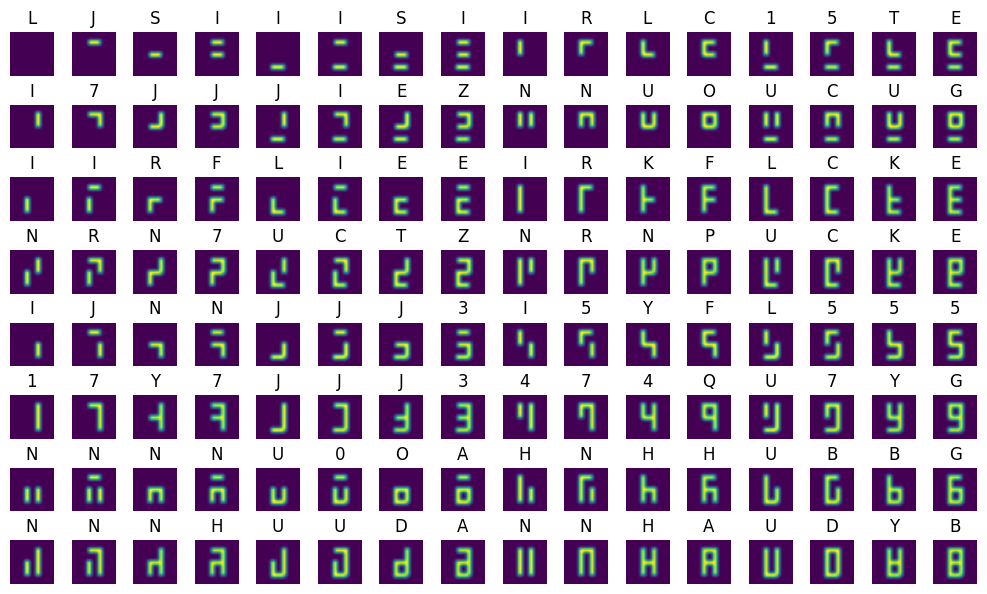

In [9]:
@jax.jit
def predict(state, img):
    out = (state.apply_fn({"params": state.params}, jnp.expand_dims(img, (0, -1)), train=False)[0])
    return out


@jax.jit
def make_7seg(i):
    L = +9
    R = -11
    U = 4
    M = 13
    D = 22
    canvas = jnp.zeros((28, 28))
    segs = [(i & (1 << n)) != 0 for n in range(7)]
    canvas = canvas.at[U, L:R].set(segs[0])
    canvas = canvas.at[M, L:R].set(segs[1])
    canvas = canvas.at[D, L:R].set(segs[2])
    canvas = canvas.at[U : M, L].set(segs[3])
    canvas = canvas.at[U : M, R].set(segs[4])
    canvas = canvas.at[M : D, L].set(segs[5])
    canvas = canvas.at[M : D, R].set(segs[6])
    canvas = (
        canvas
        + jnp.roll(canvas, 1, axis=0)
        + jnp.roll(canvas, 1, axis=1)
        + jnp.roll(canvas, 2, axis=0)
        + jnp.roll(canvas, 2, axis=1)
        + jnp.roll(jnp.roll(canvas, 1, axis=0), 1, axis=1)
        + jnp.roll(jnp.roll(canvas, 2, axis=0), 2, axis=1)
    )
    canvas = 255 * (canvas != 0)
    canvas = jsp.signal.convolve2d(canvas, jnp.array([[1., 2., 1.], [2., 4., 2.], [1., 2., 1.]]) / 16)
    canvas = jsp.signal.convolve2d(canvas, jnp.array([[1., 2., 1.], [2., 4., 2.], [1., 2., 1.]]) / 16)

    return canvas


plt.figure(figsize=(10, 6))
for i in range(128):
    plt.subplot(8, 16, i + 1)
    img = np.array(make_7seg(i))
    plt.imshow(img)
    import string

    chars = string.digits + string.ascii_uppercase
    name = (
        chars[predict(state, img).argsort()[-1]]
    )
    plt.title(name)
    plt.axis("off")
plt.tight_layout()

Finally, let's use memo to design a "font" by reasoning with respect to this computer vision model. We'll consider a subset of "well formed" characters to avoid getting too out of distribution from the training data.

In [10]:
from memo import memo

U = jnp.array([27, 40, 42, 43, 44, 45, 46, 47, 53, 55, 57, 59, 61, 62, 63, 79, 80, 81, 84, 87, 89, 90, 91, 94, 95, 102, 106, 109, 110, 111, 116, 117, 118, 119, 121, 122, 123, 124, 125, 127])
R = jnp.arange(36)
R_display = jnp.array([0, chars.index("O"), 1, chars.index("I"), 2, chars.index("Z"), 9, chars.index("G"), 6, chars.index("B"), chars.index("K"), chars.index("T")])

@jax.jit
def pretrained_classifier(u, r):
    return predict(state, make_7seg(u))[r]

@memo
def speaker[u: U, r: R](beta, t):
    cast: [speaker, listener]
    speaker: knows(r)
    speaker: chooses(u in U, wpp=exp(beta * pretrained_classifier(u, r)) if t == 0 else exp(beta * listener[u, r](beta, t)))
    return E[speaker.u == u]

@memo
def listener[u: U, r: R](beta, t):
    cast: [listener, speaker]
    listener: thinks[
        speaker: given(r in R, wpp=1),
        speaker: chooses(
            u in U,
            wpp=speaker[u, r](beta, t - 1),
        )
    ]
    listener: observes [speaker.u] is u
    listener: chooses(r in R, wpp=E[speaker.r == r])
    return E[listener.r == r]

Now, we can see how the emergent convention / "font" changes as we add more levels of recursive reasoning.

CPU times: user 3.99 s, sys: 124 ms, total: 4.11 s
Wall time: 1.33 s


CPU times: user 543 ms, sys: 40.4 ms, total: 584 ms
Wall time: 94.2 ms


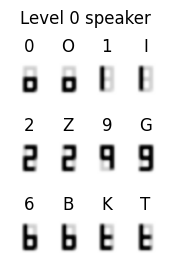

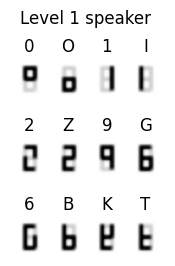

In [11]:
grid_full = make_7seg(127)
grid_full = grid_full / (255 * 5)

for t in range(2):
    plt.figure(figsize=(2, 3))
    plt.gcf().subplots_adjust(top=0.9, hspace=0, wspace=0)
    %time S = speaker(2.0, t)
    plt.suptitle(f'Level {t} speaker', y=1.0)
    for i in range(len(R_display)):
        plt.subplot(3, 4, i+1)
        grid = make_7seg(U[jnp.argmax(S[:, R_display[i]])])
        grid = grid / 255
        grid = grid + grid_full
        grid = np.stack([grid, grid, grid], axis=-1)
        grid = 1 - grid
        plt.imshow(np.clip(grid, 0., 1.))
        plt.title(chars[R_display[i]])
        plt.axis("off")
    plt.savefig(f"7seg-{t}.pdf")